In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import math
from sklearn.model_selection import train_test_split
from scipy.signal import convolve2d
from numpy.lib.stride_tricks import sliding_window_view
from numpy.lib.stride_tricks import as_strided
from sklearn.utils import shuffle

print("Libraries loaded")


Libraries loaded


In [18]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zalando-research/fashionmnist")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fashionmnist


In [19]:
base_dir = path
print(os.listdir(base_dir))
test_path = os.path.join(base_dir, 'fashion-mnist_test.csv')
train_path = os.path.join(base_dir, 'fashion-mnist_train.csv')
print(test_path)
print(train_path)

['t10k-labels-idx1-ubyte', 't10k-images-idx3-ubyte', 'fashion-mnist_test.csv', 'fashion-mnist_train.csv', 'train-labels-idx1-ubyte', 'train-images-idx3-ubyte']
/kaggle/input/fashionmnist/fashion-mnist_test.csv
/kaggle/input/fashionmnist/fashion-mnist_train.csv


In [20]:
data_test = pd.read_csv(test_path)
df_train = pd.read_csv(train_path)
X = np.asarray(df_train.drop('label', axis=1)) / 255
y = np.asarray(df_train['label'])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123, shuffle=True
)
m_train, _ = X_train.shape
test_size = X_test.shape[0]
img_size = (28, 28)
X_train = X_train.reshape(m_train, *img_size, 1)
X_test = X_test.reshape(test_size, *img_size, 1)
print(X_train.shape)
print(X_test.shape)



(48000, 28, 28, 1)
(12000, 28, 28, 1)


(28, 28, 1)


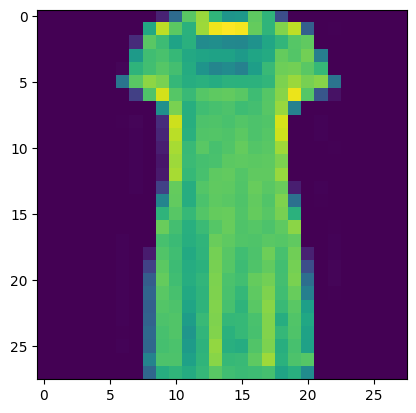

3


In [21]:
def show_img(data):
    print(data.shape)
    plt.imshow(data)
    plt.show()
random = np.random.randint(0, 100)
show_img(X_train[random])
print(y_train[random])



In [22]:
def show_output(output):
    num_kerns = output.shape[-1]
    N = math.ceil(num_kerns ** 0.5)
    fig, axes = plt.subplots(N, N, figsize=(N*1, N*1))
    for i, ax in enumerate(axes.flatten()):
        ax.set_title(f"Image after filter {i}", fontsize=5)
        ax.imshow(output[:, :, i], cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [23]:
def get_padded(inputs, H_pad, W_pad):
    if H_pad > 0 or W_pad > 0:
        outputs = np.pad(
            inputs, 
            ((0, 0), (H_pad, H_pad), (W_pad, W_pad),(0, 0))
        )
    else:
        outputs = inputs
    return outputs
class Layer_Conv:
    def __init__(self, num_kerns=16, kH=3, kW=3, num_chans=3):
        self.num_kerns = num_kerns
        self.kH = kH
        self.kW = kW
        self.num_chans = num_chans
        #parameters
        limit = np.sqrt(2.0 / (kH * kW * num_chans))
        self.W = np.random.randn(num_kerns, kH, kW, num_chans) * limit
        self.b = np.zeros(num_kerns)
    def forward(self, inputs, padding=0, stride=1):
        self.stride = stride
        self.inputs = inputs
        self.padding = padding
        # print("-----------------------")
        # print("Convolution Layer: ")
        #image parameter (200, 128, 128, 3)
        N, H, W, C = inputs.shape
        #kernel shape (16, 3, 3, 3)
        self.N = N
        num_kerns, kH, kW = self.num_kerns, self.kH, self.kW
        #output shape (128(batch size), 128, 128, 10)
        H_out = int((H - kH + padding * 2) / stride + 1)
        W_out = int((W - kW + padding * 2) / stride + 1)
        inputs_padded = get_padded(inputs, padding, padding)
        self.inputs_padded = inputs_padded
        patches = sliding_window_view(
            inputs_padded, 
            (kH, kW),                           
            axis=(1, 2))[:, ::stride, ::stride].transpose(0, 1, 2, 4, 5, 3)
        outputs = np.tensordot(patches, self.W, axes=([3,4,5],[1,2,3])) #proved (Nimg, H,W,numkerns)
        outputs = outputs + self.b
        self.outputs = outputs
        self.patches = patches
        # print("output shape: ", outputs.shape)
        # print("----------------------------------")  
        return self.outputs
    def backward(self, dA):
        # res = np.zeros_like(self.W, dtype=float) #(num_kerns, kH, kW, num_chans)
        # for sample in range(self.samples_size):
        #     for kernel in range(self.num_kerns):
        #         for chan in range(self.num_chans):
        #             for h in range(self.kH):
        #                 for w in range(self.kW):
        #                     coef = self.patches[sample, :, :, h, w, chan];
        #                     res[kernel, h, w, chan] += np.sum(coef * dA[sample, :, :, kernel])
        # dA shape (n_sample, H, W, num_kerns)
        # patches shape (n_sample,H,W,kH,kW,numChans)
        # print(res.shape)
        # print(np.allclose(dW, res))
        dZ = dA
        self.dZ = dZ
        dW = (1/self.N) * np.tensordot(self.patches, dZ, axes=([0, 1, 2], [0, 1, 2])).transpose(3, 0, 1, 2)
        db = (1/self.N) * np.sum(dZ, axis=(0, 1, 2))
        #for dW we can use dW = convolve(inputs, dZ) with stride = 1   
        #for stride = 2, use convolve(inputs, upsample(dZ))
        # input_patches = extract_patches(self.inputs_padded, self.kH, self.kW, self.stride)
        #patches shape (N, H_out, W_out, kH, kW, C)
        #dZ shape (N, H_out, W_out, num_kerns)
        # dW_test = np.tensordot(
        #     self.dZ, input_patches,
        #     axes=([0, 1, 2], [0, 1, 2])
        # )
        #calc dA_prev = full convole(dZ, W_rotate_180)
        #-> pad dZ -> extract patches -> tensordot
        W_rot = self.W[:, ::-1, ::-1, :]
        H_pad, W_pad = self.kH - 1 - self.padding, self.kW - 1 - self.padding
        dZ_upsample = upsample4d(dZ, self.stride)
        dZ_pad = get_padded(dZ_upsample, H_pad, W_pad)
        # dZ_patches = extract_patches(dZ_pad, self.kH, self.kW, 1) #same with below
        dZ_patches = sliding_window_view(dZ_pad, (self.kH, self.kW), axis=(1, 2))
        #patches (N, H_up, W_up, numkern, kH, kW)
        #W_rot (num_kerns, kH, kW, C)
        dA_prev = np.tensordot(
            dZ_patches, W_rot,
            axes=([3,4,5], [0,1,2])
        )
        #dA_prev (N, H_in, W_in, C)
        self.dW = dW
        self.db = db
        self.dA_prev = dA_prev
        # print("dA_prev shape: ", dA_prev.shape)
        return dA_prev
def extract_patches(X, kH, kW, stride):
    N, H_in, W_in, C = X.shape
    H_out = (H_in - kH)//stride + 1
    W_out = (W_in - kW)//stride + 1
    s0, s1, s2, s3 = X.strides
    patches = as_strided(
        X, shape=(N, H_out, W_out, kH, kW, C),
        strides=(s0, s1*stride, s2*stride, s1, s2, s3),
    )
    return patches
def upsample4d(X, stride):
    N, H, W, C = X.shape
    H_up = (H - 1) * (stride - 1) + H
    W_up = (W - 1) * (stride - 1) + W
    outputs = np.zeros((N, H_up, W_up, C))
    outputs[:, ::stride, ::stride, :] = X
    return outputs
    
test_conv = Layer_Conv(32, 3, 3, 8)
arr = np.random.rand(10, 28, 28, 8)
outputs = test_conv.forward(arr, 1, 1)
fake_dA = np.random.rand(*test_conv.outputs.shape)
a = test_conv.backward(fake_dA)
print(a.shape)

        
        
        

(10, 28, 28, 8)


In [24]:
a = np.random.randint(1, 10, 10)
window = 3
n = 10
print(a)
stride = a.strides[0]
patches = as_strided(a, shape=(n - window + 1, window), strides=(stride, stride))
print(patches)

[6 1 3 3 2 2 3 5 8 8]
[[6 1 3]
 [1 3 3]
 [3 3 2]
 [3 2 2]
 [2 2 3]
 [2 3 5]
 [3 5 8]
 [5 8 8]]


In [25]:
class Layer_Max_Pooling:
    def forward(self, inputs, kH=2, kW=2, stride=2):
        # print("------------------------------------")
        # print("Max Pooling Layer")
        #inputs are output of conv layer (Nimgs,H,W,num_kernels)
        patch_shape = (kH, kW)
        patches = sliding_window_view(inputs, patch_shape, axis=(1, 2))[:, ::stride, ::stride]
        #patches_shape (N_imgs,H,W,num_chans,kH,kW)
        outputs = np.max(patches, axis=(-1, -2))
        masks = (patches == outputs[..., None, None]) #for back prop
        # print("outputs shape: ", outputs.shape)
        self.inputs = inputs
        self.outputs = outputs
        self.masks = masks
        self.kH = kH
        self.kW = kW
        self.stride = stride
        return self.outputs
        #checked
    def backward(self, dA):
        """
        dA: (N, H_out, W_out, C)
        masks: (N, H_out, W_out, C, kH, kW)
        returns: dA_MP (N, H_in, W_in, C)
        """
        self.dA = dA #(samples_size, H, W, num_chans) e.g (320, 16, 16, 64)
        # print(dA.shape)
        samples_size, H, W, num_chans = dA.shape
        dA_MP = np.zeros_like(self.inputs, dtype=float)
        stride, kH, kW = self.stride, self.kH, self.kW
        #masks shape: (N, H_out, W_out, C, kH, kW)
        patches = self.masks[:, :, :, :] * dA[:, :, :, :, None, None] #(N, H_out, W_out, C, kH, kW)
        patches = patches.transpose(0, 1, 2, 4, 5, 3) #(N, H_out, W_out, kH, kW, C)
        for h in range(H):
            for w in range(W):
                h_start = h * stride
                h_end = h_start + kH
                w_start = w * stride
                w_end = w_start + kW
                dA_MP[:, 
                h_start:h_end, 
                w_start:w_end, 
                :] += patches[:, h, w, :, :, :]
        #check
        self.outputs = dA_MP
        return dA_MP
        

arr = np.random.randint(1, 10, (100, 16, 16, 10))
MP1 = Layer_Max_Pooling()
dA_fake = MP1.forward(arr, 2, 2, 3)
res = MP1.backward(dA_fake)
print(res.shape)

# show_output(MP1.outputs[0])
# print("---------------------------------------")

(100, 16, 16, 10)


In [26]:
class ReLu:
    def forward(self, inputs):
        self.mask = (inputs > 0)
        return np.maximum(0, inputs)
    def backward(self, dA):
        return dA * self.mask
class SoftMax:
    def forward(self, z): #shape(inputs, sample_size)
        ez = np.exp(z - np.max(z, axis=0, keepdims=True))
        self.outputs = ez / np.sum(ez, axis=0, keepdims=True)
        return self.outputs
    def backward(self, dA):
        return dA
        

In [27]:
class Flatten:
    def forward(self, inputs):
        # print('--------------------------------------')
        # print('Flatten:')
        self.inputs = inputs
        sample_size = inputs.shape[0]
        outputs = inputs.reshape(sample_size, -1)
        self.outputs = outputs.T #shape (n_flatten, sample_size)
        # print('output shape: ', self.outputs.shape)
        return self.outputs
    def backward(self, dA):
        self.dA_flatten = dA # shape: (n_flatten, sample_size)
        #convert back to -> (samples_size, H, W, num_chan) (320, 16, 16, 64)
        self.dA_origin = dA.T.reshape(self.inputs.shape)
        return self.dA_origin
        
test = Flatten()
arr = np.random.rand(12, 16, 16, 32)
abc = test.forward(arr)
print(abc.shape)
xyz = test.backward(abc)
print(np.allclose(arr, xyz))

(8192, 12)
True


In [28]:
class Layer_Dense:
    def __init__(self, n_neurons, n_inputs, activation='relu'):
        self.n_neurons = n_neurons
        self.n_inputs = n_inputs #shape (n_flatten, sample_size)
        limit = np.sqrt(2. / n_inputs) if activation == 'relu' else np.sqrt(1. / n_inputs)
        self.W = np.random.randn(n_neurons, n_inputs) * limit
        self.b = np.zeros((n_neurons, 1), dtype=float)
        # self.W = np.random.rand(n_neurons, n_inputs)
        # self.b = np.random.rand(n_neurons, 1)
        if activation == 'relu':
            self.activation = ReLu()
        elif activation == 'softmax':
            self.activation = SoftMax()
        else:
            raise ValueError("activation must be either relu or softmax")
    def forward(self, inputs):
        self.inputs = inputs
        self.z = self.W @ inputs + self.b
        self.A = self.activation.forward(self.z)
        return self.A
    def backward(self, dA):
        dZ = self.activation.backward(dA)
        m = self.inputs.shape[1]
        self.dW = (1/m) * (dZ @ self.inputs.T)
        self.db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
        dA_prev = self.W.T @ dZ
        return dA_prev
class FC:
    def __init__(self, n_neurons, n_inputs, n_classes):
        self.hidden_layer = Layer_Dense(n_neurons, n_inputs, activation='relu')
        self.output_layer = Layer_Dense(n_classes, n_neurons, activation='softmax')
        self.n_classes = n_classes
    def forward(self, inputs):
        A1 = self.hidden_layer.forward(inputs)
        self.y_hat = self.output_layer.forward(A1) #(2, sample_size)
        self.prediction = np.argmax(self.y_hat, axis=0)
        return self.prediction
    def backward(self, dA):
        dA_hidden = self.output_layer.backward(dA)
        dA_inputs = self.hidden_layer.backward(dA_hidden)
        return dA_inputs
#check and test this FC
def one_hot(y, n_classes):
    m = y.shape[0]
    one_hot_y = np.zeros((n_classes, m))
    one_hot_y[y, range(len(y))] = 1
    return one_hot_y
        

In [53]:
class MyCNN:
    def __init__(self, n_inputs_FC, C_in, n_classes):
        self.Conv = [       
            Layer_Conv(8, 3, 3, C_in),
            Layer_Conv(16, 3, 3, 8),
            Layer_Conv(32, 3, 3, 16)
        ]
        self.ReLu = [
            ReLu(),
            ReLu(),
            ReLu()
        ]
        self.MP = [
            Layer_Max_Pooling(),
            Layer_Max_Pooling(),
            Layer_Max_Pooling()
        ]
        self.Flatten = Flatten()
        self.FC = FC(128, n_inputs_FC, n_classes)
        self.n_classes = n_classes
    def forward(self, inputs):
        outputs_before = inputs
        #conv -> relu -> max_pool
        for i in range(len(self.Conv)):
            outputs_conv = self.Conv[i].forward(outputs_before, 1, 1)
            outputs_relu = self.ReLu[i].forward(outputs_conv)
            outputs_before = self.MP[i].forward(outputs_relu, 2, 2, 2)
        # #flatten 
        flatten_imgs = self.Flatten.forward(outputs_before)
        #fully connected layer
        self.prediction = self.FC.forward(flatten_imgs)
        self.y_hat = self.FC.y_hat
        return self.prediction
    def backward(self, dA):
        #fully connected layer
        dA_flatten = self.FC.backward(dA) #shape(n_flatten, n_samples)
        dA_before_flatten = self.Flatten.backward(dA_flatten) #shape(n_samples,H,W,num_chans)
        dA_before = dA_before_flatten
        # print(dA_before.shape)
        for i in reversed(range(len(self.Conv))):
            # print("Layer: ", i)
            dA_MP = self.MP[i].backward(dA_before)
            dA_ReLu = self.ReLu[i].backward(dA_MP)
            dA_before = self.Conv[i].backward(dA_ReLu)
        
        
        

In [30]:
def get_accuracy(y_hat, y):
    return np.sum(y_hat == y) / y.size

In [61]:
def get_batches(X_train, y_train, batch_size):
    sample_size = X_train.shape[0]
    total_batches = math.ceil(sample_size / batch_size)
    for i in range(total_batches):
        cur_slice = range(i * batch_size, np.minimum((i + 1) * batch_size, sample_size))
        X_batch = X_train[cur_slice]
        y_batch = y_train[cur_slice]
        yield X_batch, y_batch
def update_params(lr):
    #fully connected layer
        #ouput
    myCNN.FC.output_layer.W = myCNN.FC.output_layer.W - lr * myCNN.FC.output_layer.dW
    myCNN.FC.output_layer.b = myCNN.FC.output_layer.b - lr * myCNN.FC.output_layer.db
        #hidden
    myCNN.FC.hidden_layer.W = myCNN.FC.hidden_layer.W - lr * myCNN.FC.hidden_layer.dW
    myCNN.FC.hidden_layer.b = myCNN.FC.hidden_layer.b - lr * myCNN.FC.hidden_layer.db
    #conv2d layer
    N_layers = len(myCNN.Conv)
    for i in reversed(range(N_layers)):
        # print(myCNN.Conv[i].dW.max(), myCNN.Conv[i].dW.min())
        myCNN.Conv[i].W -= lr * myCNN.Conv[i].dW
        myCNN.Conv[i].b -= lr * myCNN.Conv[i].db
def get_test(X_test, y_test):
    N = X_test.shape[0]
    idx = np.random.choice(N, size=5000, replace=False)
    X_random, y_random = X_test[idx], y_test[idx]
    return X_random, y_random
myCNN = MyCNN(288, 1, 10)

In [66]:
def train(X_train, y_train, epochs=1, batch_size=128, lr=0.01):
    accuracy_list = []
    decay_rate = 0.9
    step = 2
    init_lr = 0.01
    for epoch in range(epochs): 
        X_train, y_train = shuffle(X_train, y_train, random_state=42)
        lr = init_lr * (decay_rate ** (epoch // step))
        for i, (X_batch, y_batch) in enumerate(get_batches(X_train, y_train, batch_size)):
            prediction = myCNN.forward(X_batch)
            dA = myCNN.y_hat - one_hot(y_batch, myCNN.n_classes)
            accuracy = get_accuracy(prediction, y_batch)
            accuracy_list.append(accuracy)
            # print(accuracy, np.unique(prediction, return_counts=True))
            # print(accuracy, np.unique(myCNN.prediction, return_counts=True))
            myCNN.backward(dA)
            update_params(lr)
            if i % 100 == 0:
                test_pred = myCNN.forward(X_test)
                test_accuracy = get_accuracy(test_pred, y_test)
                print(f"Epoch {epoch} - Batch {i}: ")
                print(f"Training accuracy: ", accuracy)
                print(f"Random test accuracy: ", test_accuracy)                   
        if epoch % 10 == 0:
            print(f"Epoch {epoch} - accurarcy {accuracy}")
batch_size = 128
lr = 0.01 * (0.9 ** 10)
train(X_train, y_train, 10, batch_size, lr)  

Epoch 0 - Batch 0: 
Training accuracy:  0.96875
Random test accuracy:  0.8901666666666667
Epoch 0 - Batch 100: 
Training accuracy:  0.90625
Random test accuracy:  0.8876666666666667
Epoch 0 - Batch 200: 
Training accuracy:  0.8984375
Random test accuracy:  0.8841666666666667
Epoch 0 - Batch 300: 
Training accuracy:  0.8984375
Random test accuracy:  0.8895
Epoch 0 - accurarcy 0.8828125
Epoch 1 - Batch 0: 
Training accuracy:  0.9453125
Random test accuracy:  0.88875
Epoch 1 - Batch 100: 
Training accuracy:  0.890625
Random test accuracy:  0.8904166666666666
Epoch 1 - Batch 200: 
Training accuracy:  0.9140625
Random test accuracy:  0.88675
Epoch 1 - Batch 300: 
Training accuracy:  0.90625
Random test accuracy:  0.8916666666666667
Epoch 2 - Batch 0: 
Training accuracy:  0.84375
Random test accuracy:  0.8925
Epoch 2 - Batch 100: 
Training accuracy:  0.9296875
Random test accuracy:  0.8911666666666667
Epoch 2 - Batch 200: 
Training accuracy:  0.921875
Random test accuracy:  0.890083333333333

In [ ]:
a = [1, 2, 3]
print(np.mean(a))